# Classifier based on curve parametrization 


- https://en.wikipedia.org/wiki/Softmax_function
- https://en.wikipedia.org/wiki/Smooth_maximum
- http://www.leadinglesson.com/problem-on-taking-the-gradient-of-a-composition-of-functions
- https://gist.github.com/sagarmainkar/41d135a04d7d3bc4098f0664fe20cf3c
- https://www.geeksforgeeks.org/how-to-find-gradient-of-a-function-using-python/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class CategoricalCurveModel:
    
    def __init__(self, pol_degree = 3, alpha = 5):
        self.alpha = alpha #alpha value for the smooth maximum function
        self.pol_degree = pol_degree
    
    def compute_coords(self):
        # coords = (a_0 + b_0t + c_0t^2, a_1 + b_1t + c_1t^2, a_2 + b_2t + c_2t^2)
        # shape of theta => (n_categories, pol_degree)
        # shape of X_pol => (pol_degree, n_points)
        # shape of coords => (n_points, n_categories)
        return self.theta.dot(self.X_pol).T
    
    def get_X_pol(self, X):
        # defines the curve monomials (1,t,t^2) from the input data: Later we compute the dot product between theta @ X_pol
        return np.array([X**i for i in range(self.pol_degree)]).reshape((self.pol_degree,len(X))) # (1,t,t^2)
        
    def get_Sα_max_coord(self):
        #return np.array([smooth_maximum(v, self.alpha) for v in self.coords])
        #return self.coords.max(axis = 1)
        max_coord_pos = np.abs(self.coords).argmax(axis = 1)
        return np.array([c[pos] for c, pos in zip(self.coords,max_coord_pos)])
    
    def g(self):
        #g(t_i) = a_i + b_it + c_it^2
        correct_coord = np.array([c[pos] for c, pos in zip(self.coords,self.arg_correct_coord)])
        return correct_coord

    def dg_dθ(self):
        # derivative of g respect to each theta coeficient given a specific data point.
        return self.X_pol # (1,t,t^2)

    def softmax_coord(self):
        # returns the softmax of the class coordinate to which a given point belongs.
        softmax_values = np.array([softmax(self.alpha*v) for v in self.coords])
        return np.array([c[pos] for c, pos in zip(softmax_values,self.arg_correct_coord)])

    def cost(self):
        #f(x_i) = Sα(|x_1|,...,|x_n|) - |x_i|
        #cost(t_i) = f(g(t_i))
        return np.abs(self.get_Sα_max_coord()) - np.abs(self.g())

    
    def grad_cost(self):
        self.coords = self.compute_coords()

        gθ = self.g()
        dgdθ = self.dg_dθ()
        Sα_max_coord = self.get_Sα_max_coord()
        dfdθ = (np.sign(gθ) * dgdθ * softmax(self.alpha * np.abs(gθ)) * (1 + self.alpha*(np.abs(gθ) - np.abs(Sα_max_coord))) - np.sign(gθ) * dgdθ).T
        theta_update = np.zeros((len(self.X),self.n_categories,self.pol_degree))
        for i, arg, θ in zip(range(len(X)), self.arg_correct_coord, dfdθ):
            theta_update[i,arg] = θ
        #print(theta_update)
        return theta_update.sum(axis = 0)
    
    
    def fit(self, X, y, learning_rate = 0.01, iterations=100, compute_accuracy = True):
        self.X = X
        self.y = y
        self.categories = sorted(np.unique(y))
        self.n_categories = len(self.categories)
        self.map_dim_cat = {c : i for i,c in enumerate(self.categories)}
        self.map_cat_dim = {i : c for i,c in enumerate(self.categories)} #used for the output
        
        self.arg_correct_coord = np.vectorize(self.map_dim_cat.get)(y)
        
        self.theta = 0.1*(np.random.random(size = (self.n_categories, self.pol_degree)) - 0.5) #we initialize the weights for the curve
        self.X_pol = self.get_X_pol(X)
        self.coords = self.compute_coords()
        
        self.theta_history = np.array([self.theta])
        self.cost_history = np.array([self.cost()])
        self.coords_history = np.array([self.coords])
        self.acc_history = []
        
        for it in range(iterations):
            model.theta = model.theta - (1/len(self.y))*learning_rate*(model.grad_cost())
            
            if compute_accuracy:
                y_pred = model.predict(X)
                self.acc_history.append(accuracy_score(y_pred = y_pred, y_true = y))
            self.theta_history = np.append(self.theta_history,[model.theta], axis = 0)
            self.cost_history = np.append(self.cost_history,[model.cost()], axis = 0)
            self.coords_history  = np.append(self.coords_history, [self.coords], axis = 0)
    
    def predict(self, X):
        X_pol = self.get_X_pol(X)
        coords = self.theta.dot(X_pol).T #coords of the predicted points in feature space
        return np.vectorize(self.map_cat_dim.get)(np.abs(coords).argmax(axis = 1)) #we get the max coordinate and return its associated category
        

In [4]:
#original
#dfdθ = -(np.sign(gθ) * dgdθ - np.sign(Sα_max_coord) * dgdθ * softmax(self.alpha*gθ) * (1 + self.alpha*(gθ - Sα_max_coord))).T

#correcta segun teoría
#dfdθ = (np.sign(gθ) * dgdθ * softmax(self.alpha * np.abs(gθ)) * (1 + self.alpha*(np.abs(gθ) - np.abs(Sα_max_coord))) - np.sign(gθ) * dgdθ).T


In [5]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [6]:
def smooth_maximum(x, alpha = 5):
    return (x*np.exp(alpha*x)).sum()/np.exp(alpha*x).sum()

In [7]:
categories = ["A", "B", "C"]
map_dim_cat = {c : i for i,c in enumerate(categories)}
n_categories = len(categories)
n_variables = 1
n_points = 500

pol_degree = 3

In [8]:

X = np.random.random([n_points,n_variables])
y = np.random.choice(categories, n_points)

In [9]:
df = pd.concat([pd.DataFrame(X),pd.DataFrame(y)], 1)
df.columns = [f"x_{i}" for i in range(X.shape[1])] + ["y"]

/var/folders/cx/865gkv912xj3_mfvrtptff_r0000gp/T/ipykernel_80339/3268355298.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([pd.DataFrame(X),pd.DataFrame(y)], 1)


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

#### Made up classification problem 

In [76]:
from sklearn.datasets import make_classification

n_features = 1
n_classes = 3
X, y = make_classification(n_samples=700, 
                           n_features=20, 
                           n_informative=20,
                           n_classes = n_classes,
                           n_redundant=0,
                           random_state=41)

X = X[:,:n_features]

#### Iris dataset classification dataset

In [78]:


iris = load_iris()
X = iris.data[:, :1]  # we only take the first feature for now.
y = iris.target_names[iris.target]
pd.value_counts(y)

setosa        50
versicolor    50
virginica     50
dtype: int64

### Benchmark

In [79]:
X = sc.fit_transform(X)

In [80]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = None, solver='lbfgs', multi_class='auto', penalty = "none")
clf.fit(X, y)
y_pred_benchmark = clf.predict(X)

In [102]:
model = CategoricalCurveModel(pol_degree = 5, alpha=5)
model.fit(X,y, learning_rate = 0.001, iterations=1500)

best_weights_id = np.array(model.acc_history).argmax()
model.theta = model.theta_history[best_weights_id]
y_pred = model.predict(X)

In [103]:
cost_through_epochs = model.cost_history.sum(axis = 1)
sum_theta_through_epochs = np.abs(model.theta_history).sum(axis = (1,2))

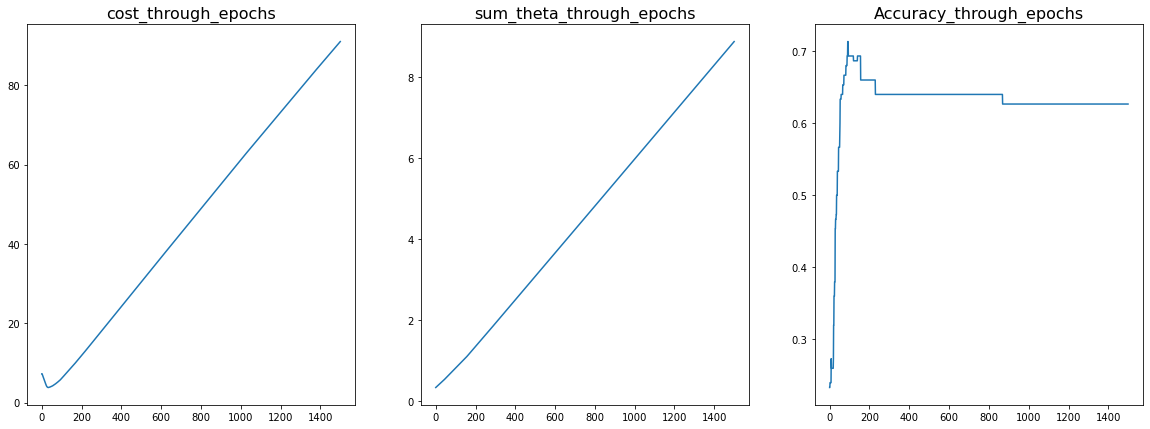

In [104]:
%matplotlib inline
fig, ax = plt.subplots(ncols = 3, figsize = (20,7))
cost_plot, theta_plot, acc_plot = ax
cost_plot.set_title("cost_through_epochs", size = 16)
cost_plot.plot(cost_through_epochs)
theta_plot.set_title("sum_theta_through_epochs", size = 16)
theta_plot.plot(sum_theta_through_epochs)
acc_plot.set_title("Accuracy_through_epochs", size = 16)
acc_plot.plot(model.acc_history)

In [105]:
acc = accuracy_score(y_pred = y_pred, y_true = y)
acc_benchmark = accuracy_score(y_pred = y_pred_benchmark, y_true = y)
max_accuracy = max(model.acc_history)
print(f"End Accuracy = {acc}")
print(f"Max Accuracy = {max_accuracy}")
print(f"Accuracy Logistic Regression = {acc_benchmark}")

End Accuracy = 0.6933333333333334
Max Accuracy = 0.7133333333333334
Accuracy Logistic Regression = 0.7466666666666667


In [106]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true= y_true, y_pred = y_pred, labels = labels)
    df_cm = pd.DataFrame(cm, index = [i for i in model.categories], columns = [i for i in labels])
    plt.figure(figsize = (6,5))
    return sns.heatmap(df_cm, annot=True)

<AxesSubplot:>

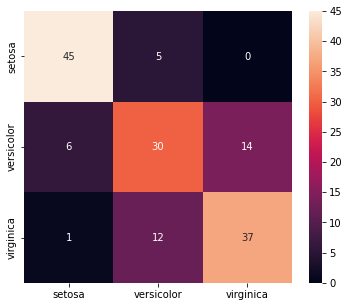

In [107]:
plot_confusion_matrix(y_pred = y_pred_benchmark, y_true = y, labels = model.categories)

<AxesSubplot:>

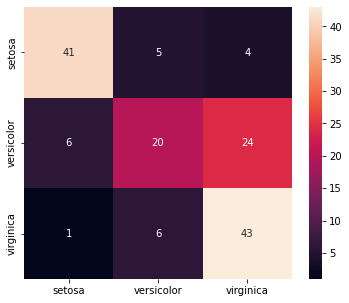

In [108]:
plot_confusion_matrix(y_pred = y_pred, y_true = y, labels = model.categories)

In [109]:
def compute_coords(X, theta):
    # coords = (a_0 + b_0t + c_0t^2, a_1 + b_1t + c_1t^2, a_2 + b_2t + c_2t^2)
    pol_degree = theta.shape[1]
    # shape of theta => (n_categories, pol_degree)
    X_pol = np.array([X**i for i in range(pol_degree)]).reshape((pol_degree,len(X)))
    # shape of X_pol => (pol_degree, n_points)
    coords = theta.dot(X_pol).T
    # shape of coords => (n_points, n_categories)
    return coords

In [110]:
epochs = len(model.theta_history)

In [138]:
start = model.X.min()
end = model.X.max()
t = np.linspace(start,end,100)
d = np.linspace(5*start,5*end,100)
d0 = np.zeros(d.shape)
colors = { name: color for name, color in zip(model.map_dim_cat, ["tab:green", "tab:orange", "tab:blue"])}
color_list = list(map(colors.get, model.y))

def plot_epochs(epoch):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot( aspect='auto', projection='3d')
    coords = compute_coords(t, model.theta_history[epoch])
    x, y, z = coords.T
    ax.plot(x,y,z)
    x_,y_,z_ = model.coords_history[epoch].T
    ax.scatter(x_,y_,z_, c = color_list, alpha = 0.6)
    
    ax.plot(d,d,d0, c = "red", alpha = 0.2)
    ax.plot(d,d0,d, c = "red", alpha = 0.2)
    ax.plot(d0,d,d, c = "red", alpha = 0.2)
    ax.plot(d,-d,d0, c = "red", alpha = 0.2)
    ax.plot(-d,d0,d, c = "red", alpha = 0.2)
    ax.plot(d0,-d,d, c = "red", alpha = 0.2)
    
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    plt.show()
plt.close()

In [139]:
%matplotlib ipympl
import ipywidgets as widgets
from IPython.display import display

epochs = len(model.theta_history)
my_3dgraph = widgets.interactive(plot_epochs, epoch = (1, epochs - 1, 20))


In [142]:
# If ipympl is not working problem.
# pip install --update jupyter-lab
# pip uninstall ipympl
# pip install ipympl

In [140]:
plt.show()
display(my_3dgraph)

interactive(children=(IntSlider(value=741, description='epoch', max=1500, min=1, step=20), Output()), _dom_cla…

# BORRADOR

In [664]:
#dummy example
X = np.array([[3],[5]])
theta = np.array(
      [[1, 2, 3, 4],
       [2, 3, 4, 5],
       [5, 6, 7, 8]])


In [686]:
map_dim_cat

{'A': 0, 'B': 1, 'C': 2}

In [690]:
np.array([map(map_dim_cat.get, y)])

array([<map object at 0x7fcee09d2280>], dtype=object)

In [791]:
(np.abs(correct_coord) - np.abs(max_coord)).round(2)

array([-0.69, -0.64, -0.64, -0.69, -0.52,  0.01, -0.82, -0.74, -0.57,
        0.  , -0.94,  0.  ,  0.  ,  0.  , -1.17,  0.  , -0.78, -0.68,
        0.  , -0.69, -1.23,  0.  , -0.88,  0.  ,  0.  ,  0.  , -0.47,
        0.  ,  0.  , -0.85])

In [846]:
gθ = g(X=X, y = y, theta=theta)

array([0.18863416, 0.84774788, 0.87267988, 0.18749214, 0.49007247,
       0.8676768 , 0.27311599, 0.2305656 , 0.61057829, 1.23100538,
       0.325014  , 1.74574036, 1.2178195 , 1.59174494, 0.39611367,
       1.53574215, 0.25131314, 1.09227806, 1.00530146, 0.17882359,
       0.41324186, 1.18970811, 0.30212389, 0.96426078, 1.14782746,
       1.75955012, 0.42096253, 1.10166653, 1.58777094, 0.28644477])

In [880]:
gθ = g(X=X, y = y, theta=theta)
softmax(3*gθ)

array([0.00169692, 0.01225774, 0.01320973, 0.00169112, 0.00419181,
       0.01301295, 0.00218641, 0.00192439, 0.00601736, 0.03870352,
       0.00255475, 0.18129678, 0.03720238, 0.11422259, 0.00316216,
       0.0965577 , 0.00204798, 0.0255273 , 0.01966457, 0.00164771,
       0.00332889, 0.0341936 , 0.00238521, 0.01738655, 0.03015638,
       0.18896554, 0.0034069 , 0.02625651, 0.11286892, 0.00227561])

In [429]:
a = np.arange(10)
a = np.stack([a for i in range(10)])

In [430]:
a

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [871]:
def dg_dθ(X, theta):
    # coords = (a_0 + b_0t + c_0t^2, a_1 + b_1t + c_1t^2, a_2 + b_2t + c_2t^2)
    pol_degree = theta.shape[1]
    X_pol = np.array([X**i for i in range(pol_degree)]).reshape((pol_degree,len(X)))
    return X_pol # (1,t,t^2)
    

def f(**kwargs):
    X, y, theta = kwargs.get("X"), kwargs.get("y"), kwargs.get("theta")
    coords = compute_coords(X, theta)
    max_coord = np.array([smooth_maximum(v, 10) for v in coords])
    cost = np.abs(np.abs(g(y = y, coords = coords)) - np.abs(max_coord))
    return cost
    

def softmax_value():
    softmax_coord = np.array([softmax(alpha*v) for v in coords])
    arg_correct_coord = np.vectorize(map_dim_cat.get)(y)
    return np.array([c[pos] for c, pos in zip(softmax_coord,arg_correct_coord)])

softmax_value

def g(**kwargs):
    X, y, theta, coords = kwargs.get("X"), kwargs.get("y"), kwargs.get("theta"),  kwargs.get("coords")
    if coords is None:
        coords = compute_coords(X, theta)
    arg_correct_coord = np.vectorize(map_dim_cat.get)(y)
    correct_coord = np.array([c[pos] for c, pos in zip(coords,arg_correct_coord)])
    return correct_coord
    

In [872]:
g(coords = coords, y = y)

array([0.18863416, 0.84774788, 0.87267988, 0.18749214, 0.49007247,
       0.8676768 , 0.27311599, 0.2305656 , 0.61057829, 1.23100538,
       0.325014  , 1.74574036, 1.2178195 , 1.59174494, 0.39611367,
       1.53574215, 0.25131314, 1.09227806, 1.00530146, 0.17882359,
       0.41324186, 1.18970811, 0.30212389, 0.96426078, 1.14782746,
       1.75955012, 0.42096253, 1.10166653, 1.58777094, 0.28644477])

In [7]:
def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    
    
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

### Mejoras
 * No necesita crear 1 variable por cada categoría (one-hot-encoding)
 * Cada eje es igual de distante de los demás

In [1]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [9]:
%matplotlib inline


In [116]:
t = np.linspace(-b,b,b*2*100)


r = lambda t : 1*np.sin(t/10) + 1 #t + t**2
x = lambda t : r(t)*np.sin(np.pi*t)
y = lambda t : r(t)*np.cos(np.pi*t)


In [128]:
points = np.vstack([x(t), y(t)]).T

points.shape

(600, 2)

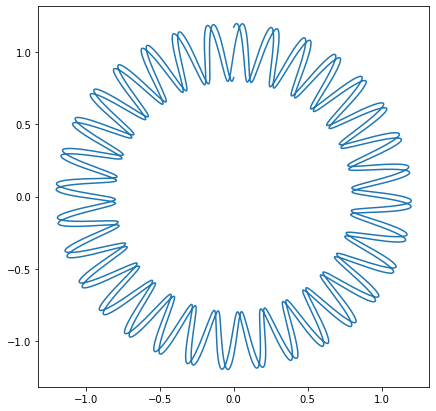

In [249]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

ax = None
if ax is None:
    ax = plt.figure(figsize = (7,7)).add_subplot()
else:
    ax.clear()

# Prepare arrays x, y, z
b = 2
t = np.linspace(-b,b,b*2*1000)


r = lambda t : 0.2*np.sin(100*t) + 1
#r = lambda t : 0.1*np.sin(100*t) + 2
#r = lambda t : (100*t + 200*t - 200*t**2)*0.1*np.sin(100*t) + 1
x = lambda t : r(t)*np.sin(np.pi*t)
y = lambda t : r(t)*np.cos(np.pi*t)

ax.plot(x(t), y(t))